In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [9]:
data = pd.read_csv("./data/features3_train_2.csv")
X = data[data.columns[:-1]]
y = data['VV']

In [10]:
random_seed = 42
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=random_seed)

In [12]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE,SVMSMOTE
oversample = SVMSMOTE()
X_over, y_over = oversample.fit_resample(X_train, y_train)
y_over.value_counts()

0    19170
1    19170
Name: VV, dtype: int64

In [15]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=50, min_samples_leaf=1000, random_state=42)
model.fit(X_over, y_over)

y_train_pred = model.predict(X_over)
y_valid_pred = model.predict(X_valid)

from sklearn.metrics import f1_score
print(f1_score(y_over, y_train_pred))
print(f1_score(y_valid, y_valid_pred))

0.9234571715455318
0.26140567200986436


In [17]:
from sklearn.model_selection import GridSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [10, 64, 118, 173, 227, 282, 336, 391, 445, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [20]:
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rfc_gs = GridSearchCV(estimator = model, param_grid=random_grid, cv = 5, verbose=2, n_jobs = -1, scoring='f1_weighted',)
# Fit the random search model
rfc_gs.fit(X_over, y_over)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(min_samples_leaf=1000,
                                              n_estimators=50,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'min_samples_leaf': [100, 200, 300, 400, 500, 600, 700,
                                              800, 900, 1000],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 64, 118, 173, 227, 282, 336, 391,
                                          445, 500]},
             scoring='f1_weighted', verbose=2)

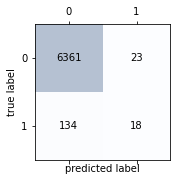

In [12]:
from sklearn.metrics import confusion_matrix

confmt = confusion_matrix(y_true=y_valid, y_pred=y_valid_pred)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmt, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmt.shape[0]):
    for j in range(confmt.shape[1]):
        ax.text(x=j, y=i, s=confmt[i, j], va='center', ha='center')
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

In [13]:
from xgboost.sklearn import XGBClassifier
model = XGBClassifier( learning_rate =0.1,n_estimators=1000,max_depth=5,
 min_child_weight=20,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.8,
 #objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
model.fit(X_over, y_over,eval_metric='auc')
train_pred = model.predict(X_train)
test_pred = model.predict(X_valid)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [14]:
print(f1_score(train_pred,y_train))
print(f1_score(y_valid, test_pred))

0.7999999999999999
0.2830188679245283


In [15]:
from lightgbm.sklearn import LGBMClassifier
lgb =LGBMClassifier(random_state=42)
lgb.fit(X_over, y_over)

train_pred = model.predict(X_train)
test_pred = model.predict(X_valid)
print(f1_score(train_pred,y_train))
print(f1_score(y_valid, test_pred))

0.7999999999999999
0.2830188679245283


In [17]:
param_grid = {
    'max_depth': [5, 6, 7, 8, 9, 10]
}
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(estimator=lgb, param_grid=param_grid, scoring='f1_weighted', cv=5)
gs.fit(X_over, y_over)
print("best score: %.4f, and best params: %s" % (gs.best_score_, gs.best_params_))
y_pred = gs.predict(X_valid)
print("LightGBM f1_score: %.4f%%" % (f1_score(y_valid, y_pred) * 100))

best score: 0.9864, and best params: {'max_depth': 8}
LR f1_score: 30.2222%


In [20]:
param_grid = {
    'min_child_samples': [5, 10, 20, 30, 40, 50, 100]
}
lgb = LGBMClassifier(max_depth=8, random_state=42)
gs = GridSearchCV(estimator=lgb, param_grid=param_grid, scoring='f1_weighted', cv=10)
gs.fit(X_over, y_over)
print("best score: %.4f, and best params: %s" % (gs.best_score_, gs.best_params_))
y_pred = gs.predict(X_valid)
print("LightGBM f1_score: %.4f%%" % (f1_score(y_valid, y_pred) * 100))

best score: 0.9863, and best params: {'min_child_samples': 10}
LR f1_score: 32.8889%


In [22]:
param_grid = {
    'num_leaves': [7, 15, 31, 48, 51]
}
lgb = LGBMClassifier(boosting_type='dart', max_depth=8, num_leaves=48, min_child_samples=10, random_state=42)
gs = GridSearchCV(estimator=lgb, param_grid=param_grid, scoring='f1_weighted', cv=10)
gs.fit(X_over, y_over)
print("best score: %.4f, and best params: %s" % (gs.best_score_, gs.best_params_))
y_pred = gs.predict(X_valid)
print("LightGBM f1_score: %.4f%%" % (f1_score(y_valid, y_pred) * 100))

best score: 0.9829, and best params: {'num_leaves': 48}
LR f1_score: 30.1003%


In [25]:
param_grid = {
    'reg_lambda': [0.01, 0.1, 1, 10, 100, 1000]
}
lgb = LGBMClassifier(boosting_type='dart', max_depth=8, num_leaves=31, min_child_samples=10, random_state=42)
gs = GridSearchCV(estimator=lgb, param_grid=param_grid, scoring='f1_weighted', cv=10)
gs.fit(X_over, y_over)
print("best score: %.4f, and best params: %s" % (gs.best_score_, gs.best_params_))
y_pred = gs.predict(X_valid)
print("LightGBM f1_score: %.4f%%" % (f1_score(y_valid, y_pred) * 100))

best score: 0.9819, and best params: {'reg_lambda': 0.1}
LR f1_score: 29.3160%


In [18]:
lgb.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
# learning_rate, max_depth, l2_regularization, max_bins
